In [1]:
'''
ICC Tutorial - June 14, 2021
Tutorial 14: Machine Learning for MIMO Systems with Large Arrays
Aldebaro Klautau (UFPA), Nuria Gonzalez-Prelcic (NCSU) and Robert W. Heath Jr. (NCSU)
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import commpy.modulation as cm
import commpy.utilities as cu
from numpy.random import randn, random, standard_normal
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense,
    LSTM,
    Dropout,
    Lambda,
    Flatten,
    TimeDistributed,
)
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler

from ml4comm.qam_analyzer import plot_decision_boundary, ser

## Time variant channel problem
Consider a situation where a crazy channel has a cyclic behavior in time, where each time a symbol is sent through the channel the channel has one of 5 possible behaviors. This causes an interesting case, where a conventional classifier can get confused as it probably will not understand the cyclic behavior and therefore will make wrong class predictions.

This way, in this case, a model that can understand the time dependencies of the input can learn the cyclic behavior and predict the correct class as output. In this sense, the long short-term memory(LSTM) model was chosen, as it is prepared to deal with sequence inputs and understand the temporal relationship between them.  

In [2]:
def generate_symbols(transmissions=100, M=16):
    """
    Parameters
    ----------
    transmissions: int
        Number of transmissions. Default is 100.
    M: int
        Number of symbols in the constellation. Default is 16.
    Returns
    -------
    """
    bits_per_QAMsymbol = int(np.log2(M))
    bitarrays = [cu.dec2bitarray(obj, bits_per_QAMsymbol)
                 for obj
                 in np.arange(0, M)]
    #print(bitarrays)
    qammod = cm.QAMModem(M)
    const = []
    for i in range(len(bitarrays)):
        const.append(qammod.modulate(bitarrays[i]))
    # unit average power
    constellation = const / np.sqrt((M - 1) * (2 ** 2) / 6)

    ind = np.random.randint(M, size=[1, transmissions])

    # QAM symbols for each antenna
    x = constellation[ind]
    #Reshape to (num_elements,) instead of (num_elements,1)
    #https://www.semicolonworld.com/question/59886/numpy-vector-n-1-dimension-gt-n-dimension-conversion
    x = x.reshape((-1,))
    ind = ind.reshape((-1,))
    return x, ind


In [3]:
def variable_crazy_channel_propagate(x, n_patterns=5):
    """
    Parameters
    ----------
    x:
        Array of symbols to be propagated in the time variable channel.
    n_patterns:
        Number of time variable patterns
    Returns
    -------
    y:
        Channel output
    noise:
        Noise added to the channel input
    """
    y = np.zeros(x.shape, dtype=np.complex_)
    num_samples = x.shape[0]
    # Noise parametter depending in the amount of patterns
    n_params = {'std':           np.random.uniform( low=0.1, high=0.125, size=n_patterns),
                'pwr_factor':    np.random.uniform( low=0.002, high=0.0035, size=n_patterns),
                'i_mag':    np.random.uniform( low=-1, high=1, size=n_patterns),
                'r_mag':    np.random.uniform( low=-1, high=1, size=n_patterns)}

    # The std and pwr_factor affect snr, while i_mag affects the disposition of the symbols
    for i in range(x.shape[1]):
        gaussian_noise = (n_params['r_mag'][i]*standard_normal(num_samples) \
                            + n_params['i_mag'][i]*1j * standard_normal(num_samples)) \
                            * n_params['std'][i] * 0.5
        noise = np.abs(x[:,i])*n_params['pwr_factor'][i] + gaussian_noise

        if i == 0:
            y[:,i] = x[:,i] * noise + 1/x[:,i]
        elif i == 1:
            y[:,i] = (x[:,i] * noise + 1/x[:,i]) * (np.cos(1.25663706144*i)+1j*np.sin(1.25663706144*i))
        elif i == 2:
            y[:,i] = (x[:,i] * noise + 1/x[:,i]) * (np.cos(1.25663706144*i)+1j*np.sin(1.25663706144*i))
        elif i == 3:
            y[:,i] = x[:,i] + (noise * 1/x[:,i])
        elif i == 4:
            y[:,i] = (x[:,i] * noise - 1/x[:,i]) * (np.cos(np.pi/2)+1j*np.sin(np.pi/2))
    
    return np.array(y).flatten()

In [4]:
n_patterns = 5
M = 16
num_of_symbols = 1000*n_patterns
symbs, indices=generate_symbols(transmissions=num_of_symbols, M=M)
symbs = np.reshape(symbs, (int(len(symbs)/n_patterns),n_patterns))

#transmit over the channel
channel_output = variable_crazy_channel_propagate(symbs, n_patterns)

In [5]:
# Generate dataset
# Train
train_size = int(0.5*len(indices))
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

## Lets have a glimpse of the channel output

In [6]:
def plot_symbols(ch_out_symbs, true_symbs, indices, num_classes):
    custom_cmap = cmap.get_cmap('tab20')
    colors = custom_cmap.colors[:num_classes]
    levels = np.arange(num_classes + 2) - 0.5
    y_train = indices[:len(ch_out_symbs)]
    for ii in range(num_classes):
        selected_indices = np.argwhere(y_train==ii)
        selected_indices = selected_indices.reshape((-1))
        plt.plot(ch_out_symbs[selected_indices, 0], ch_out_symbs[selected_indices, 1], 'o', color=colors[ii], label=f'{ii}')
        
    plt.plot(np.real(true_symbs), np.imag(true_symbs), 'rx')
    plt.legend(title='Classes', bbox_to_anchor=(1, 1), loc='upper left', ncol=2, handleheight=2, labelspacing=0.05, frameon=False)
    plt.ylabel('Quadrature')
    plt.xlabel('In-phase')

    plt.show()  

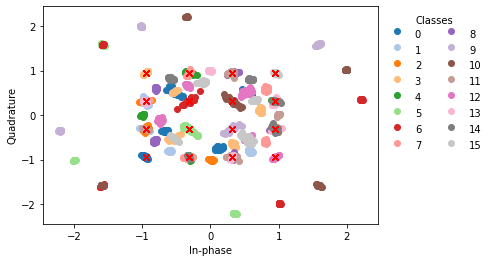

In [7]:
plot_symbols(X_train, symbs, indices, M)

## There is 5 different patterns in this output, these patterns are cyclic in a way we can divide the original channel output into 5 distinct behaviors

In [8]:
channel_output_reshape = np.reshape(channel_output, (int(len(channel_output)/n_patterns),n_patterns))
indices_reshape = np.reshape(indices, (int(len(indices)/n_patterns),n_patterns))

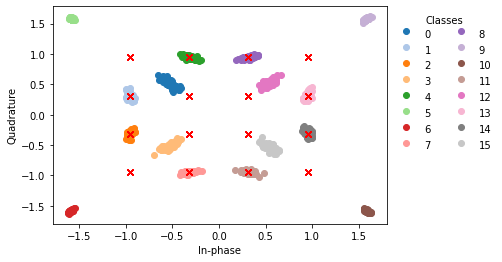

In [9]:
channel_output_slice = np.stack([np.real(channel_output_reshape[:,0][:train_size]),
                     np.imag(channel_output_reshape[:,0][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices_reshape[:,0], M)

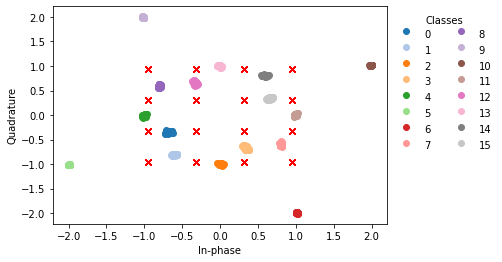

In [10]:
channel_output_slice = np.stack([np.real(channel_output_reshape[:,1][:train_size]),
                     np.imag(channel_output_reshape[:,1][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices_reshape[:,1], M)

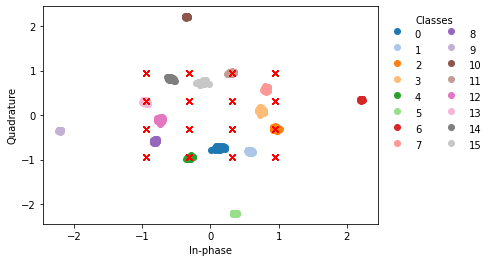

In [11]:
channel_output_slice = np.stack([np.real(channel_output_reshape[:,2][:train_size]),
                     np.imag(channel_output_reshape[:,2][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices_reshape[:,2], M)

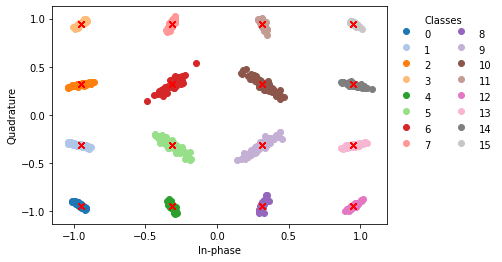

In [12]:
channel_output_slice = np.stack([np.real(channel_output_reshape[:,3][:train_size]),
                     np.imag(channel_output_reshape[:,3][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices_reshape[:,3], M)

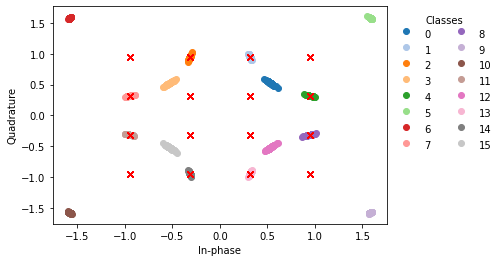

In [13]:
channel_output_slice = np.stack([np.real(channel_output_reshape[:,4][:train_size]),
                     np.imag(channel_output_reshape[:,4][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices_reshape[:,4], M)

## Now let us try to train a model to predict the symbol desired location without the notion of time dependence behavior

## Decision Tree

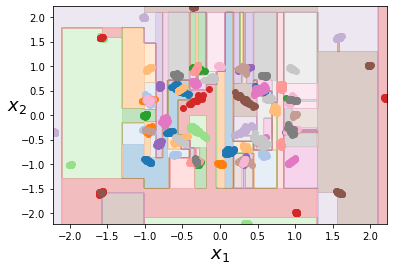

In [14]:
class_DT = DecisionTreeClassifier(max_depth=20, random_state=42)
class_DT.fit(X_train, y_train)
plot_decision_boundary(class_DT, X_train, y_train)

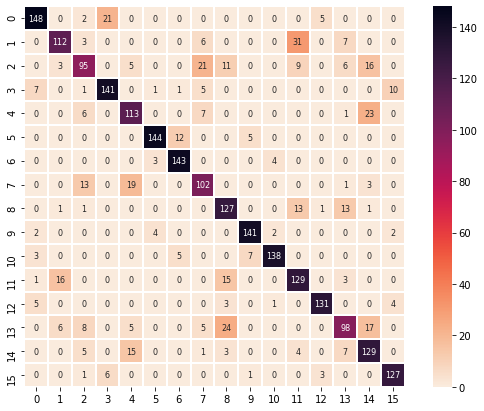

In [15]:
y_pred = class_DT.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(M)],
                  columns = [i for i in range(M)])
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8})  
plt.show()

In [16]:
ser = ser(class_DT, X_test, y_test)
print(f'Decision Tree:\n SER:\t {ser:.3f}')

acc = accuracy_score(y_test, y_pred)
print(f' Acc:\t {acc:.3f}')

Decision Tree:
 SER:	 0.193
 Acc:	 0.807


## Now let us fit a model that has the notion of time dependency

The model chosen to do so is the long short-term memory(LSTM), with the help of recurrence, this model can take multiple symbols as entry and predict the last symbol class. This way the model can learn the cyclic behavior produced by the variable channel and potentially learn each cycle. 

In [17]:
features = np.stack([np.real(channel_output),
                    np.imag(channel_output)], axis=1)

### First let us generate rolling windows of symbols as the features to our LSTM model

In [18]:
def rolling_window_mtx(x, window_size):
        """Compute all overlapping (rolling) observation windows over a vector 
            and return a matrix

        Args:
            x           : observation vector that is supposed to be split into
                          overlapping windows
            window_size : the target window size

        Returns:

            Window matrix with all windows as rows. That is, if n_windows is the
            number of windows, the result has dimensions:

            (n_windows, window_size)

        """
        if window_size < 1:
            raise ValueError("`window_size` must be at least 1.")
        if window_size > x.shape[-1]:
            raise ValueError("`window_size` is too long.")

        shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
        strides = x.strides + (x.strides[-1],)

        return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [19]:
n_time_steps = 18 # window size
scaler = MinMaxScaler((-1,1)) # Scale the symbol real and imaginary part
scaler.fit(features)
features = scaler.transform(features)

n_windows   = features.shape[0] - n_time_steps - 1 # Total number of Rolling windows
feature_win = 2 * n_time_steps # Real and imaginnary coordinates of 5 instances
feature_mtx = np.zeros((n_windows, feature_win))
x_train_r = features[:,0]
x_train_i = features[:,1]
rolling_window_mtx( x_train_r[:-1], n_time_steps).shape

# Get the real coordinates and allocate to the first set of columns
feature_mtx[:, range(0, n_time_steps * 2, 2)] = rolling_window_mtx(
     x_train_r[:-1], n_time_steps)[:-1]

# Now we have a set of windows of the real coordinate
# Lets take a look in one window
print(f"\n One window containing just the real coordinates : \n {feature_mtx[0]}")

# Do the same for the imaginary coordinates
feature_mtx[:, range(1, n_time_steps * 2, 2)] = rolling_window_mtx(
                        x_train_i[:-1], n_time_steps)[:-1]

# Lets take a look in the same window
print(f"\n One window with all the coordinates: \n {feature_mtx[0]}")


 One window containing just the real coordinates : 
 [ 0.70829114  0.          0.27805933  0.          0.15279641  0.
 -0.44318726  0.          0.43247246  0.          0.22464496  0.
  0.89285214  0.         -0.13707552  0.         -0.41173084  0.
  0.23519874  0.         -0.43601809  0.          0.26098617  0.
  0.36055006  0.         -0.13784764  0.          0.42772308  0.
 -0.24730777  0.         -0.89287467  0.          0.1546107   0.        ]

 One window with all the coordinates: 
 [ 0.70829114  0.71788198  0.27805933  0.3650314   0.15279641 -0.99603094
 -0.44318726  0.13436292  0.43247246 -0.14084422  0.22464496  0.25011146
  0.89285214  0.45421572 -0.13707552 -0.43155091 -0.41173084  0.43945268
  0.23519874 -0.238241   -0.43601809  0.16437518  0.26098617  0.36439208
  0.36055006  0.26577079 -0.13784764 -0.42393469  0.42772308  0.14162042
 -0.24730777  0.23042969 -0.89287467 -0.4601573   0.1546107  -0.99492978]


## Now we need to reshape this feature matrix  the LSTM network
The LSTM network receives as entry feature a matrix of 3 dimensions, these being samples, timestamps, and features. For our problem, we selected 18 timestamps of 2 features (real and imaginary coordinates). This way, the first dimension, the dimension of the sample will contain the timestamps dimension (in this case 18 timestamps) and for last each timestamp will contain 2 features.

In [20]:
shape = feature_mtx.shape

# Reshape the feature matrix to samples, timestamps, features
feature_mtx_3dim = np.reshape(
    feature_mtx, (shape[0], n_time_steps, 2))

## Generate the labels of an LSTM network
Now for the labels of the LSTM network, not all the cases require a label matrix of 3 dimensions. The cases where this is required are on sequence to sequence problems, where the model is made to predict a sequence of timestamps of one or more features. However for our problem, the LSTM network needs to predict the output class of the last timestamp feature, this way we can use a label matrix of 2 dimensions, these being samples and label class.

In [21]:
# Get the labels for the feature matrix
label_mtx = rolling_window_mtx(
                    indices[n_time_steps-1:], 1)[:-2]


### Now that we have the label matrix containing the output class we can transform it to a categorical form with a one-hot encoding transformation.

In [22]:
label_mtx_cat = tf.keras.utils.to_categorical(label_mtx)

### With the dataset well defined we can divide between training and test sets and observe one sample of the training features and labels

In [23]:
size = feature_mtx_3dim.shape[0]
lstm_x_train = feature_mtx_3dim[:int(0.5*size)] # Split in 50% the dataset in training and test
lstm_x_test  = feature_mtx_3dim[int(0.5*size):]

lstm_y_train = label_mtx_cat[:int(0.5*size)]
lstm_y_test  = label_mtx_cat[int(0.5*size):]

# Lets take a look in the same window
print(f"One sample unit of the LSTM entry features: \n {lstm_x_train[0]}")
print(f"LSTM features shape: \n {lstm_x_train.shape}")
print(f"\n One sample unit of the LSTM labels: \n {lstm_y_train[0]}")
print(f"LSTM labels shape: \n {lstm_y_train.shape}")

One sample unit of the LSTM entry features: 
 [[ 0.70829114  0.71788198]
 [ 0.27805933  0.3650314 ]
 [ 0.15279641 -0.99603094]
 [-0.44318726  0.13436292]
 [ 0.43247246 -0.14084422]
 [ 0.22464496  0.25011146]
 [ 0.89285214  0.45421572]
 [-0.13707552 -0.43155091]
 [-0.41173084  0.43945268]
 [ 0.23519874 -0.238241  ]
 [-0.43601809  0.16437518]
 [ 0.26098617  0.36439208]
 [ 0.36055006  0.26577079]
 [-0.13784764 -0.42393469]
 [ 0.42772308  0.14162042]
 [-0.24730777  0.23042969]
 [-0.89287467 -0.4601573 ]
 [ 0.1546107  -0.99492978]]
LSTM features shape: 
 (2490, 18, 2)

 One sample unit of the LSTM labels: 
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
LSTM labels shape: 
 (2490, 16)


## Define the LSTM

In [24]:
lr=0.01
lr_decay=0.0001
optimizer = Adam(learning_rate=lr, decay=lr_decay)
n_epochs=200
n_mini_batch=60

n_timesteps, n_features, n_outputs = lstm_x_train.shape[1], lstm_x_train.shape[2], lstm_y_train.shape[1]
lstm_categorical = Sequential()
lstm_categorical.add(LSTM(100, input_shape=(n_timesteps,n_features), return_sequences=True))
lstm_categorical.add(LSTM(100))
lstm_categorical.add(Dropout(0.5))
lstm_categorical.add(Dense(100, activation='relu'))
lstm_categorical.add(Dense(100, activation='relu'))
lstm_categorical.add(Dense(n_outputs, activation='softmax'))
lstm_categorical.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


## Train the model

In [25]:
history = lstm_categorical.fit(
            lstm_x_train,
            lstm_y_train,
            batch_size=n_mini_batch,
            epochs=n_epochs,
        )

Epoch 1/200
42/42 [==============================] - 4s 50ms/step - loss: 2.7790 - accuracy: 0.0606
Epoch 2/200
42/42 [==============================] - 2s 48ms/step - loss: 2.7724 - accuracy: 0.0635
Epoch 3/200
42/42 [==============================] - 2s 45ms/step - loss: 2.7697 - accuracy: 0.0659
Epoch 4/200
42/42 [==============================] - 2s 47ms/step - loss: 2.7536 - accuracy: 0.0707
Epoch 5/200
42/42 [==============================] - 2s 42ms/step - loss: 2.6911 - accuracy: 0.0932
Epoch 6/200
42/42 [==============================] - 2s 43ms/step - loss: 2.6225 - accuracy: 0.1221
Epoch 7/200
42/42 [==============================] - 2s 42ms/step - loss: 2.5373 - accuracy: 0.1414
Epoch 8/200
42/42 [==============================] - 2s 43ms/step - loss: 2.3771 - accuracy: 0.1667
Epoch 9/200
42/42 [==============================] - 2s 43ms/step - loss: 2.3180 - accuracy: 0.1851
Epoch 10/200
42/42 [==============================] - 2s 42ms/step - loss: 2.2652 - accuracy: 0.1940

42/42 [==============================] - 2s 43ms/step - loss: 0.1456 - accuracy: 0.9590
Epoch 83/200
42/42 [==============================] - 2s 45ms/step - loss: 0.1511 - accuracy: 0.9514
Epoch 84/200
42/42 [==============================] - 2s 44ms/step - loss: 0.1541 - accuracy: 0.9490
Epoch 85/200
42/42 [==============================] - 2s 45ms/step - loss: 0.1489 - accuracy: 0.9534
Epoch 86/200
42/42 [==============================] - 2s 43ms/step - loss: 0.1231 - accuracy: 0.9602
Epoch 87/200
42/42 [==============================] - 2s 44ms/step - loss: 0.1155 - accuracy: 0.9647
Epoch 88/200
42/42 [==============================] - 2s 43ms/step - loss: 0.1437 - accuracy: 0.9550
Epoch 89/200
42/42 [==============================] - 2s 43ms/step - loss: 0.1211 - accuracy: 0.9622
Epoch 90/200
42/42 [==============================] - 2s 43ms/step - loss: 0.1057 - accuracy: 0.9687
Epoch 91/200
42/42 [==============================] - 2s 43ms/step - loss: 0.0998 - accuracy: 0.9695
Epo

42/42 [==============================] - 2s 43ms/step - loss: 0.0332 - accuracy: 0.9892
Epoch 163/200
42/42 [==============================] - 2s 43ms/step - loss: 0.0502 - accuracy: 0.9855
Epoch 164/200
42/42 [==============================] - 2s 42ms/step - loss: 0.0597 - accuracy: 0.9835
Epoch 165/200
42/42 [==============================] - 2s 47ms/step - loss: 0.0419 - accuracy: 0.9863
Epoch 166/200
42/42 [==============================] - 2s 46ms/step - loss: 0.0366 - accuracy: 0.9896
Epoch 167/200
42/42 [==============================] - 2s 46ms/step - loss: 0.0326 - accuracy: 0.9892
Epoch 168/200
42/42 [==============================] - 2s 44ms/step - loss: 0.0340 - accuracy: 0.9896
Epoch 169/200
42/42 [==============================] - 2s 43ms/step - loss: 0.0348 - accuracy: 0.9884
Epoch 170/200
42/42 [==============================] - 2s 43ms/step - loss: 0.0338 - accuracy: 0.9892
Epoch 171/200
42/42 [==============================] - 2s 43ms/step - loss: 0.0230 - accuracy: 0

Text(0.5, 0, 'epochs')

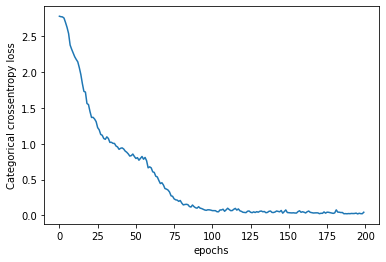

In [26]:
plt.plot(history.history["loss"])
plt.ylabel('Categorical crossentropy loss')
plt.xlabel('epochs')

## LSTM model evaluation
First let us transform the categorical output of the LSTM model to the actual classes

In [27]:
y_pred = np.round(lstm_categorical.predict(lstm_x_test))
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(lstm_y_test, axis=1)

In [28]:
ser = 1 - accuracy_score(y_test, y_pred)
print(f'LSTM:\n SER:\t {ser:.3f}')
acc = accuracy_score(y_test, y_pred)
print(f' Acc:\t {acc:.3f}')

LSTM:
 SER:	 0.008
 Acc:	 0.992


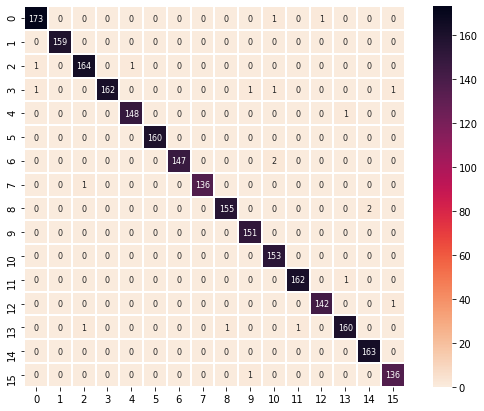

In [29]:
conf_mtx = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(M)],
                  columns = [i for i in range(M)])
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8})  
plt.show()

## Now let us re-test the Decision tree with the same inputs as the LSTM model

In [30]:
size = feature_mtx.shape[0]
x_train = feature_mtx[:int(0.5*size)] # Split in 50% the dataset in training and test
x_test  = feature_mtx[int(0.5*size):]

y_train = label_mtx[:int(0.5*size)]
y_test  = label_mtx[int(0.5*size):]

In [31]:
class_DT = DecisionTreeClassifier(max_depth=100, random_state=42)
class_DT.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=100, random_state=42)

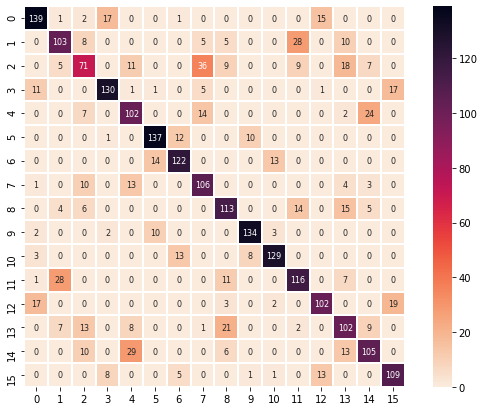

In [32]:
y_pred = class_DT.predict(x_test)
# y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)

conf_mtx = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(M)],
                  columns = [i for i in range(M)])
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8})  
plt.show()

In [33]:
ser = 1 - accuracy_score(y_test, y_pred)
print(f'Decision Tree:\n SER:\t {ser:.3f}')

acc = accuracy_score(y_test, y_pred)
print(f' Acc:\t {acc:.3f}')

Decision Tree:
 SER:	 0.269
 Acc:	 0.731


## Conclusion
With the values of the accuracy symbol error rate, and the confusion matrix is safe to assume that the LSTM model could understand the cyclic nature of the channel and predict the correct classes for the absolute majority of the test database. Although, the LSTM model is computational costly if compared to simpler models as a decision tree. Thus, the problem should be well analyzed before considering this type of solution, great tools also require great computational power.